In [44]:
from rouge_score import rouge_scorer
from pathlib import Path
import pandas as pd
from bert_score import score as bert_scorer
from nltk.translate.bleu_score import sentence_bleu


DATA_PATH = Path("../data")
OMI_PATH_predicted = DATA_PATH / "predicted" / "omi-health"


In [45]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [46]:
def calculate_rouge_scores(row):
    reference_text = str(row['soap'])
    generated_text = str(row['generated_soap_note'])

    # Ensure texts are not empty or NaN, which can cause errors
    if not reference_text or not generated_text or pd.isna(reference_text) or pd.isna(generated_text):
        return {'rouge1_precision': None, 'rouge1_recall': None, 'rouge1_fmeasure': None,
                'rouge2_precision': None, 'rouge2_recall': None, 'rouge2_fmeasure': None,
                'rougeL_precision': None, 'rougeL_recall': None, 'rougeL_fmeasure': None}

    scores = scorer.score(reference_text, generated_text)

    # Extracting precision, recall, and f-measure for each ROUGE type
    return {
        'rouge1_precision': scores['rouge1'].precision,
        'rouge1_recall': scores['rouge1'].recall,
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rouge2_precision': scores['rouge2'].precision,
        'rouge2_recall': scores['rouge2'].recall,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_precision': scores['rougeL'].precision,
        'rougeL_recall': scores['rougeL'].recall,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    }

In [47]:
test_df = pd.read_csv(OMI_PATH_predicted / "test_v1.csv")
test_df

,dialogue,soap,prompt,messages,messages_nosystem,event_tags,generated_soap_note
0,"Doctor: Hello, can you please tell me about yo...","S: The patient, a flooring installer with no s...",Create a medical SOAP summary of this dialogue.,"[{'role': 'system', 'content': 'You are an exp...","[{'role': 'user', 'content': ""You are an exper...",[],S: The patient reports experiencing painless b...
1,"Doctor: Hello, I understand that you're a 7-ye...",S: The patient is a 7-year-old boy with congen...,Create a medical SOAP summary of this dialogue.,"[{'role': 'system', 'content': 'You are an exp...","[{'role': 'user', 'content': ""You are an exper...",[],S: The patient is a 7-year-old male with conge...
2,"Doctor: Hello, we've received your results fro...",S: The patient reported undergoing an ultrasou...,Create a medical SOAP summary of this dialogue.,"[{'role': 'system', 'content': 'You are an exp...","[{'role': 'user', 'content': ""You are an exper...",[],S: The patient reports a single thyroid nodule...
3,"Doctor: Hello, can you tell me what brought yo...","S: The patient reports a progressive headache,...",Create a medical SOAP summary of this dialogue.,"[{'role': 'system', 'content': 'You are an exp...","[{'role': 'user', 'content': ""You are an exper...",[],"S: The patient reports progressive headache, n..."
4,"Doctor: Hello, I understand that you have been...","S: The patient, a post-liver transplant recipi...",Create a medical SOAP summary of this dialogue.,"[{'role': 'system', 'content': 'You are an exp...","[{'role': 'user', 'content': ""You are an exper...",[],"S: The patient, diagnosed with hepatocellular ..."
...,...,...,...,...,...,...,...
245,"Doctor: Hello, how can I help you today?\nPati...","S: The patient reports experiencing ataxia, tr...",Create a medical SOAP summary of this dialogue.,"[{'role': 'system', 'content': 'You are an exp...","[{'role': 'user', 'content': ""You are an exper...",[],"S: The patient reports experiencing ataxia, tr..."
246,"Doctor: Hello, I'm Dr. Smith. How can I help y...","S: Patient reports abdominal pain for 2 weeks,...",Create a medical SOAP summary of this dialogue.,"[{'role': 'system', 'content': 'You are an exp...","[{'role': 'user', 'content': ""You are an exper...",[],S: The patient reports experiencing abdominal ...
247,"Doctor: Hi there, I see that you've presented ...","S: The patient, a 10-year post-diagnosis breas...",Create a medical SOAP summary of this dialogue.,"[{'role': 'system', 'content': 'You are an exp...","[{'role': 'user', 'content': ""You are an exper...",[],S: The patient reports experiencing nausea and...
248,"Doctor: Hello, I understand that you were diag...","S: The patient, previously diagnosed with infe...",Create a medical SOAP summary of this dialogue.,"[{'role': 'system', 'content': 'You are an exp...","[{'role': 'user', 'content': ""You are an exper...",[],"S: The patient, diagnosed with infectious cerv..."


In [48]:
# Assuming your DataFrame with generated notes is called test_df
rouge_results = test_df.apply(calculate_rouge_scores, axis=1, result_type='expand')

# Join the ROUGE scores back to your original DataFrame
test_df = test_df.join(rouge_results)

In [49]:
average_rouge1_fmeasure = test_df['rouge1_fmeasure'].mean()
average_rouge2_fmeasure = test_df['rouge2_fmeasure'].mean()
average_rougeL_fmeasure = test_df['rougeL_fmeasure'].mean()

average_rouge1_precision = test_df['rouge1_precision'].mean()
average_rouge2_precision = test_df['rouge2_precision'].mean()
average_rougeL_precision = test_df['rougeL_precision'].mean()

average_rouge1_recall = test_df['rouge1_recall'].mean()
average_rouge2_recall = test_df['rouge2_recall'].mean()
average_rougeL_recall = test_df['rougeL_recall'].mean()


In [50]:
references = test_df['soap'].astype(str).tolist()
candidates = test_df['generated_soap_note'].astype(str).tolist()

valid_pairs = [(ref, gen) for ref, gen in zip(references, candidates) if ref and gen and not pd.isna(ref) and not pd.isna(gen)]

In [51]:
if not valid_pairs:
    print("No valid reference-generated text pairs found to calculate BERTScore.")
else:
    references_filtered = [pair[0] for pair in valid_pairs]
    candidates_filtered = [pair[1] for pair in valid_pairs]

    print("Calculating BERTScore. This may take some time depending on your dataset size and hardware...")

    P, R, F1 = bert_scorer(
        candidates_filtered,
        references_filtered,
        lang="en",
        model_type="bert-base-uncased",
        verbose=True,
        device="cuda"
    )

    average_bert_precision = P.mean().item()
    average_bert_recall = R.mean().item()
    average_bert_f1 = F1.mean().item()

    print(f"\nAverage BERTScore Precision: {average_bert_precision:.4f}")
    print(f"Average BERTScore Recall: {average_bert_recall:.4f}")
    print(f"Average BERTScore F1: {average_bert_f1:.4f}")

Calculating BERTScore. This may take some time depending on your dataset size and hardware...
calculating scores...
computing bert embedding.


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


computing greedy matching.


100%|██████████| 4/4 [00:00<00:00, 34.44it/s]

done in 7.07 seconds, 35.38 sentences/sec

Average BERTScore Precision: 0.7695
Average BERTScore Recall: 0.7262
Average BERTScore F1: 0.7467


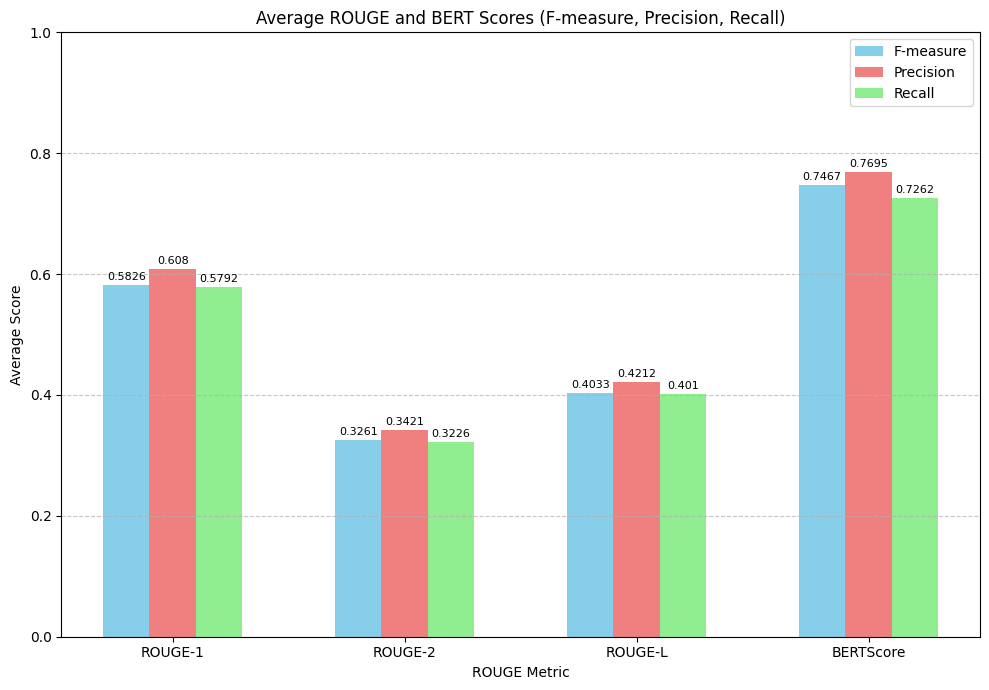

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a DataFrame for easier plotting
data = {
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore'],
    'F-measure': [average_rouge1_fmeasure, average_rouge2_fmeasure, average_rougeL_fmeasure, average_bert_f1],
    'Precision': [average_rouge1_precision, average_rouge2_precision, average_rougeL_precision, average_bert_precision],
    'Recall': [average_rouge1_recall, average_rouge2_recall, average_rougeL_recall, average_bert_recall]
}
df = pd.DataFrame(data)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 7))

bar_width = 0.2
index = np.arange(len(df['Metric']))

bar1 = ax.bar(index - bar_width, df['F-measure'], bar_width, label='F-measure', color='skyblue')
bar2 = ax.bar(index, df['Precision'], bar_width, label='Precision', color='lightcoral')
bar3 = ax.bar(index + bar_width, df['Recall'], bar_width, label='Recall', color='lightgreen')

# Add the values on top of the bars
def add_value_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom', fontsize=8)

add_value_labels(bar1)
add_value_labels(bar2)
add_value_labels(bar3)

# Add labels, title, and legend
ax.set_xlabel('ROUGE Metric')
ax.set_ylabel('Average Score')
ax.set_title('Average ROUGE and BERT Scores (F-measure, Precision, Recall)')
ax.set_xticks(index)
ax.set_xticklabels(df['Metric'], rotation=0)
ax.set_ylim(0, 1) # Set y-axis limit to better visualize differences
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

Our fine-tuned TxGemma model appears to be generating SOAP notes that are semantically very close to the original notes, as indicated by the high BERTScore. While the ROUGE scores show varying degrees of lexical and n-gram overlap (with ROUGE-2 being the lowest, as expected), the strong BERTScore suggests that the model is doing a good job of understanding the dialogue and producing relevant and meaningful summaries, which is often more important for practical applications than exact word-for-word matches.

# BLUE

In [53]:
from nltk import word_tokenize

def calculate_bleu_score(row):
    reference_text = str(row['soap'])
    generated_text = str(row['generated_soap_note'])

    # Handle potential NaN or empty strings
    if not reference_text or not generated_text or pd.isna(reference_text) or pd.isna(generated_text):
        return None

    # Tokenize the texts
    # NLTK's BLEU expects a list of reference sentences (each sentence is a list of tokens)
    # and a list of candidate tokens.
    # For a single reference, it should be in the format [[ref1_token1, ref1_token2, ...]]
    reference_tokens = [word_tokenize(reference_text.lower())]
    generated_tokens = word_tokenize(generated_text.lower())

    # Calculate BLEU score
    # Weights for BLEU-4 (1-gram, 2-gram, 3-gram, 4-gram)
    weights = (0.25, 0.25, 0.25, 0.25)
    try:
        score = sentence_bleu(reference_tokens, generated_tokens, weights=weights)
    except ZeroDivisionError:
        score = 0.0 # Assign 0 if there's a division by zero (e.g., no common n-grams)

    return score

In [54]:
test_df['bleu_score'] = test_df.apply(calculate_bleu_score, axis=1)


C:\Users\khal6952\AppData\Local\miniconda3\envs\soap\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\khal6952\AppData\Local\miniconda3\envs\soap\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [55]:
average_bleu_score = test_df['bleu_score'].mean()

print(f"Average BLEU Score: {average_bleu_score:.4f}")

Average BLEU Score: 0.2581


TxGemma model generates SOAP notes that are semantically accurate (high BERTScore: 0.7695 F1) but may not perfectly match the original phrasing (lower ROUGE-1: 0.5826 F1, ROUGE-2: 0.3261 F1, ROUGE-L: 0.4033 F1, and BLEU: 0.2581). The high BERTScore is particularly promising for medical summarization as it indicates the model captures the correct meaning, even if wording differs.